In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
# from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import contractions 
import unicodedata

In [3]:
directory = "map-charting-student-math-misunderstandings"
train = pd.read_csv(f"{directory}/train.csv")
test = pd.read_csv(f"{directory}/test.csv")

In [4]:
train.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NaN
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NaN
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NaN


In [5]:
# How many records?
len(train.index)

36696

In [6]:
# How many questions? 
print(len(train.QuestionId.unique()))
print(len(train.QuestionText.unique()))

15
15


In [7]:
# How many in each category?
train.Category.value_counts().sort_values()

Category
False_Correct            227
True_Misconception       403
True_Neither            5265
False_Neither           6542
False_Misconception     9457
True_Correct           14802
Name: count, dtype: int64

The categories ending in `_Misconception` or `_Correct` make sense to me. The student explanation contains a misconception or demonstrates that the student understands the concept. 

I'm not sure what the `_Neither` categories look like. Let's read a few examples.

In [8]:
train[train.Category == "True_Neither"].iloc[:,2:5]

,QuestionText,MC_Answer,StudentExplanation
2,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un..."
3,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine
9,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1/3 because it 3 shadedd in not all of them
13,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1/3 is also 1/3 in its simplest form.
14,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1/3 is equal to 3 because if 3 are not shared ...
...,...,...,...
36262,The probability of an event occurring is \( 0....,Likely,this is because a 9 out of 10 chance means tha...
36271,The probability of an event occurring is \( 0....,Likely,this is your answer because 1 would be certain...
36274,The probability of an event occurring is \( 0....,Likely,u can use the process of elimination because c...
36276,The probability of an event occurring is \( 0....,Likely,very high probability however it's not certain


In [9]:
train[train.Category == "False_Neither"].iloc[:,2:5]

,QuestionText,MC_Answer,StudentExplanation
2348,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),! simplefined it and that was what i got
2349,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),1 / 2
2360,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),3 bits are not shaded and six bits are shaded ...
2364,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),3 it of 6 is not shaded
2370,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),3 triangles are coloured in and the rest are blue
...,...,...,...
36691,The probability of an event occurring is \( 0....,Unlikely,very unlikely.
36692,The probability of an event occurring is \( 0....,Unlikely,yea pretty much unlikely from what it seems.
36693,The probability of an event occurring is \( 0....,Unlikely,yeah pretty unlikelyy from what it seems.
36694,The probability of an event occurring is \( 0....,Unlikely,you have 9 other numbers to get.


So the `_Neither` categories seem to mean that the student failed to explain the answer, e.g., "I simplified it and that was what I got," or they just paraphrased their answer, e.g., "yeah pretty unlikely from what it seems." 

In [10]:
# How many misconceptions, and how many types of misconceptions?
print(len(train.Misconception.unique()))
train.Misconception.value_counts().sort_index()

36


Misconception
Adding_across                              307
Adding_terms                                97
Additive                                   929
Base_rate                                   23
Certainty                                   18
Definition                                  54
Denominator-only_change                    336
Division                                    63
Duplication                                704
Firstterm                                  107
FlipChange                                  78
Ignores_zeroes                              23
Incomplete                                1454
Incorrect_equivalent_fraction_addition       9
Interior                                    50
Inverse_operation                           21
Inversion                                  414
Irrelevant                                 497
Longer_is_bigger                            24
Mult                                       353
Multiplying_by_4                            96

It looks like some of these could be combined, like `Wrong_Fraction` and `Wrong_fraction`. 
Maybe others, like `Inversion` and `Inverse_Operation`. 

I'll start by getting them all in the same format (snake case) 

In [11]:
# Standardize labels & remove special characters
train.Misconception = train.Misconception.str.lower() # all lower case
train.Misconception = train.Misconception.str.replace('-','') # remove hyphens
train.Misconception = train.Misconception.str.replace('_','') # remove underscores
train.Misconception = train.Misconception.str.replace(' ','') # remove spaces
train.Misconception.unique()

array([nan, 'incomplete', 'wnb', 'swapdividend', 'mult', 'flipchange',
       'irrelevant', 'wrongfraction', 'additive', 'notvariable',
       'addingterms', 'inverseoperation', 'inversion', 'duplication',
       'wrongoperation', 'wholenumberslarger', 'longerisbigger',
       'ignoreszeroes', 'shorterisbigger', 'addingacross',
       'denominatoronlychange', 'incorrectequivalentfractionaddition',
       'division', 'subtraction', 'unknowable', 'definition', 'interior',
       'positive', 'tacking', 'wrongterm', 'firstterm', 'baserate',
       'multiplyingby4', 'certainty', 'scale'], dtype=object)

In [12]:
# # Combine redundant categories into the one used most often
# train.loc['wnb', "Misconception"] = 'wholenumberslarger'
# train.loc['inverseoperation', "Misconception"] = 'inversion'
# train.Misconception.unique()

### QUESTION
Should I combine any of these based on their similarities? E.g. inversion & inverse operation or whole_numbers_larger & WNB? 

Yes - Aditya says ok to combine

But when I ran the cell above, I got 2 rows of null values, so I'll come back to this later

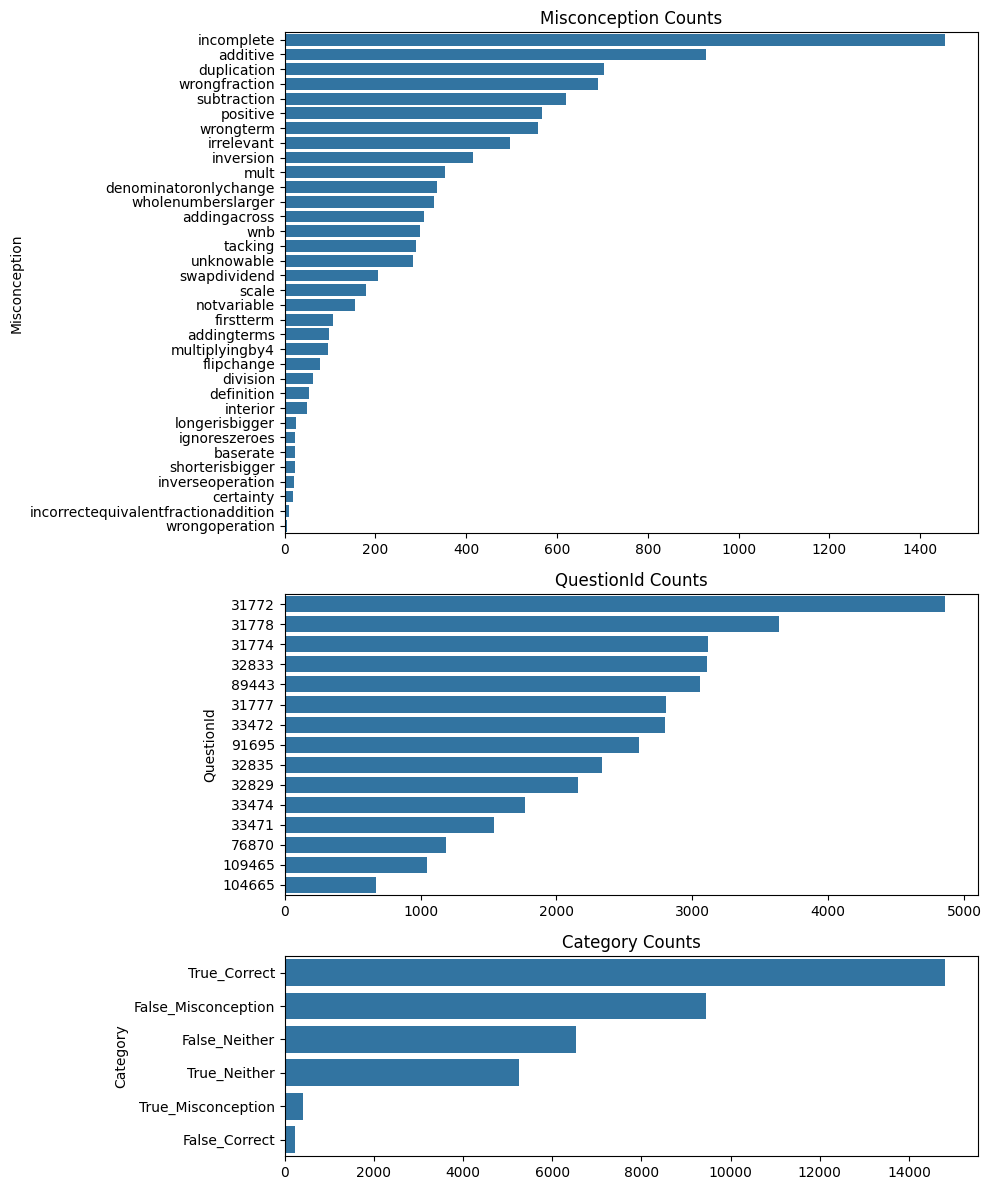

In [13]:
# Let's visualize the misconceptions, questions, and categories to look for class imbalances
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=False,
                       gridspec_kw={'height_ratios': [2.5, 1.5, 1]})

sns.barplot(y=train.Misconception.value_counts().index, 
            x=train.Misconception.value_counts().values, 
            ax=ax[0])
ax[0].set_title("Misconception Counts")

sns.barplot(y=train.QuestionId.value_counts().index.astype(str), 
            x=train.QuestionId.value_counts().values, 
            ax=ax[1])
ax[1].set_title("QuestionId Counts")

sns.barplot(y=train.Category.value_counts().index, 
            x=train.Category.value_counts().values, 
            ax=ax[2])
ax[2].set_title("Category Counts")

plt.tight_layout()
plt.show()

There is class imbalance in every categorical variable! 

In [14]:
# What about missing values?
train.isnull().sum()

row_id                    0
QuestionId                0
QuestionText              0
MC_Answer                 0
StudentExplanation        0
Category                  0
Misconception         26836
dtype: int64

In [15]:
# Lots of null values in Misconception, but not in the other categories. 
# This is probably because Misconception is null when Category != some Misconception, but let's check to be sure
train.Category[train.Misconception.isnull()].value_counts()

Category
True_Correct     14802
False_Neither     6542
True_Neither      5265
False_Correct      227
Name: count, dtype: int64

Looks good, no need to drop null rows at this point

In [16]:
# Do we have any duplicated rows? 
train.duplicated().sum()

np.int64(0)

### Free text response EDA

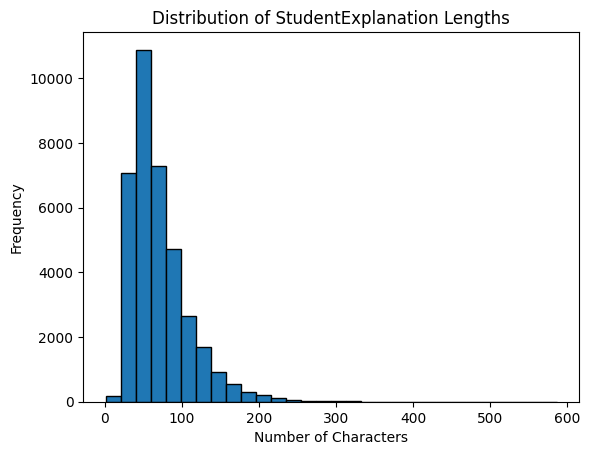

In [17]:
# Let's look at the text length distribution in terms of characters and words.
character_count = train.StudentExplanation.str.len()

plt.hist(character_count,bins=30, edgecolor='black')
plt.title('Distribution of StudentExplanation Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.show()


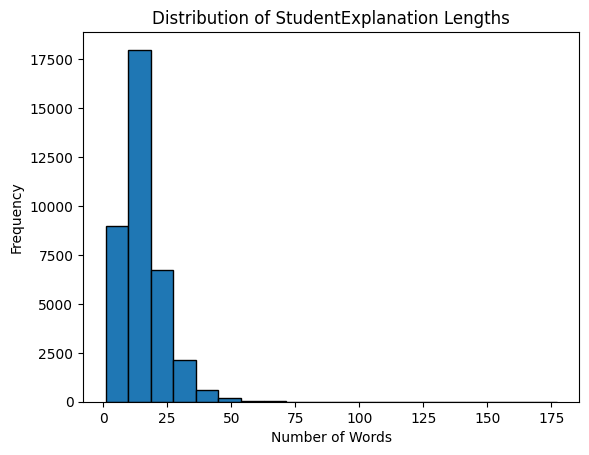

In [18]:
word_count = train.StudentExplanation.str.split().str.len()

plt.hist(word_count, bins=20, edgecolor='black')
plt.title('Distribution of StudentExplanation Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.show()

In [19]:
# These both look right skewed 
print("Character counts\n",character_count.describe(),'\n\nWord counts\n',word_count.describe())

Character counts
 count    36696.000000
mean        69.953428
std         38.658304
min          1.000000
25%         43.000000
50%         60.000000
75%         86.000000
max        586.000000
Name: StudentExplanation, dtype: float64 

Word counts
 count    36696.000000
mean        15.357832
std          8.121211
min          1.000000
25%         10.000000
50%         13.000000
75%         19.000000
max        177.000000
Name: StudentExplanation, dtype: float64


So both character and word counts have really high outliers. The mean character count is 70 words, and the mean word count is 15. Let's look at the upper outliers.

In [20]:
pd.set_option('display.max_colwidth', None)
train.StudentExplanation[train.StudentExplanation.str.len()>400]

12977                                                                                                                                                                                  Do a criss-cross. \n10 x 9 = 15 x A\nWe know this because of the equal sign. This shows that both calculations have the same answer.\n10 x 9 = 90\n90 = 15 x A\n15A = 90, therefore A= 6\nCheck:\n6/10 = 9/15 in order to check if it is correct we need to make the denominator the same. I did it by simplifying both fractions (but we could also change it to 30).\nWhen simplifying, I divided it by 2. I got 3/5 = 3/5
17022    In order to do this, you will have to turn the 5 into a 1 and then times 2 3s and 5 1s together making 10 3d. Then, using your understanding of addition and subtraction as well as working out how many 3's there are in one whole number (that is three), divide that by 3, then multiply each sidee by 2, then add both sides again until it comes to an even third (3). Finally, simplify this process 

These longer answers seem normal enough to me. 

### Text Preprocessing of StudentExplanation

### Text preprocessing steps from [NLP article](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72/)
X set case to lower

X normalize accents

X expand contractions

X DON'T remove special characters & digits in this case because they are relevant when we're talking about math problems 

X remove stop words (can customize these, e.g. remove really common words used in math, like "math problems")

X stemming / lemmatization (lemma is slower but may be more semantically correct)
- lemma will always have a valid dictionary word, good for a smaller data set 
- stemming just truncates the words, good for a really big data set
- in ML algorithm, they have very similar performances bc of word2vec

X tokenize & count frequencies

In [21]:
# Text preprocessing function
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # All lower case
    lower_text = text.lower() 

    # No accented characters
    no_accents = unicodedata.normalize('NFKD', lower_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Expand contractions
    expanded = contractions.fix(no_accents)

    # Remove repeated words
    no_repeats = re.sub(r'\b(\w+)( \1\b)+', r'\1', expanded, flags=re.IGNORECASE)

    # Remove stop words
    words = no_repeats.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

train['PreprocessedExplanation'] = train['StudentExplanation'].apply(preprocess)
train['PreprocessedExplanation']

0                  0ne third equal tree nineth
1           1 / 3 6 9 2 thirds 1 third shaded.
2        1 3rd half 3 6th, simplee understand.
3                1 goes everything 3 goes nine
4                           1 every 3 coloured
                         ...                  
36691                                unlikely.
36692          yea pretty much unlikely seems.
36693             yeah pretty unlikelyy seems.
36694                           9 numbers get.
36695            chanve think 0.9 odds chance,
Name: PreprocessedExplanation, Length: 36696, dtype: object

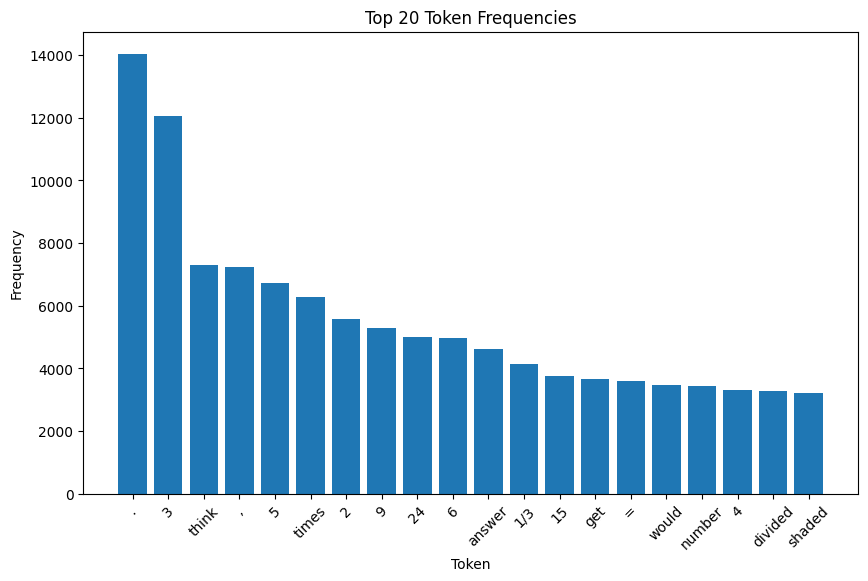

In [22]:
# Initialize tokenizer
tokenizer = ToktokTokenizer()

# Tokenize the text column
train['tokens'] = train['PreprocessedExplanation'].apply(tokenizer.tokenize)

# Flatten all tokens into one list
all_tokens = [token for tokens in train['tokens'] for token in tokens]

# Count token frequencies
token_counts = Counter(all_tokens)
token_df = pd.DataFrame(token_counts.items(), columns=['token', 'count']).sort_values(by='count', ascending=False)

# Plot top N tokens
top_n = 20
plt.figure(figsize=(10,6))
plt.bar(token_df['token'][:top_n], token_df['count'][:top_n])
plt.xticks(rotation=45)
plt.title(f"Top {top_n} Token Frequencies")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.show()


Ok, so we need to do some more processing! For the purposes of tokenizing, let's make another column of processed text with no digits or special characters.

In [23]:
def remove_special_chars_digits(text):
    # Keep only letters and spaces
    return re.sub(r'[^a-zA-Z\s]', '', text)

train['NoSpecialCharacters'] = train['PreprocessedExplanation'].apply(remove_special_chars_digits)
train['NoSpecialCharacters']

0             ne third equal tree nineth
1                   thirds  third shaded
2         rd half  th simplee understand
3             goes everything  goes nine
4                        every  coloured
                      ...               
36691                           unlikely
36692     yea pretty much unlikely seems
36693        yeah pretty unlikelyy seems
36694                        numbers get
36695          chanve think  odds chance
Name: NoSpecialCharacters, Length: 36696, dtype: object

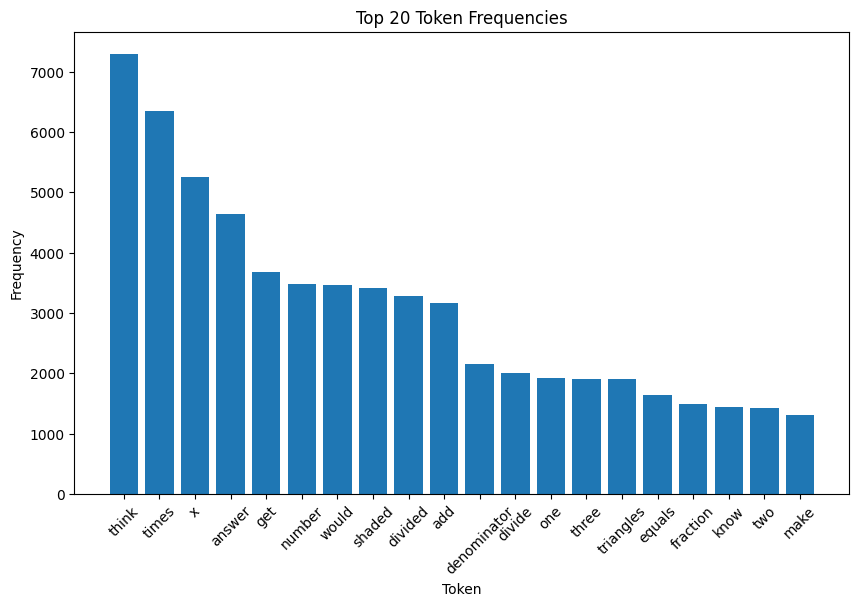

In [24]:
# Initialize tokenizer
tokenizer = ToktokTokenizer()

# Tokenize the text column
train['tokens'] = train['NoSpecialCharacters'].apply(tokenizer.tokenize)

# Flatten all tokens into one list
all_tokens = [token for tokens in train['tokens'] for token in tokens]

# Count token frequencies
token_counts = Counter(all_tokens)
token_df = pd.DataFrame(token_counts.items(), columns=['token', 'count']).sort_values(by='count', ascending=False)

# Plot top N tokens
top_n = 20
plt.figure(figsize=(10,6))
plt.bar(token_df['token'][:top_n], token_df['count'][:top_n])
plt.xticks(rotation=45)
plt.title(f"Top {top_n} Token Frequencies")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.show()

This is better, but may need more work. Discuss with Aditya. 
Let's see if we can lemmatize without it taking forever. 

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Example after tokenization
train['lemmas'] = train['tokens'].apply(lemmatize_tokens)
train[['tokens', 'lemmas']].head()

,tokens,lemmas
0,"[ne, third, equal, tree, nineth]","[ne, third, equal, tree, nineth]"
1,"[thirds, third, shaded]","[third, third, shaded]"
2,"[rd, half, th, simplee, understand]","[rd, half, th, simplee, understand]"
3,"[goes, everything, goes, nine]","[go, everything, go, nine]"
4,"[every, coloured]","[every, coloured]"


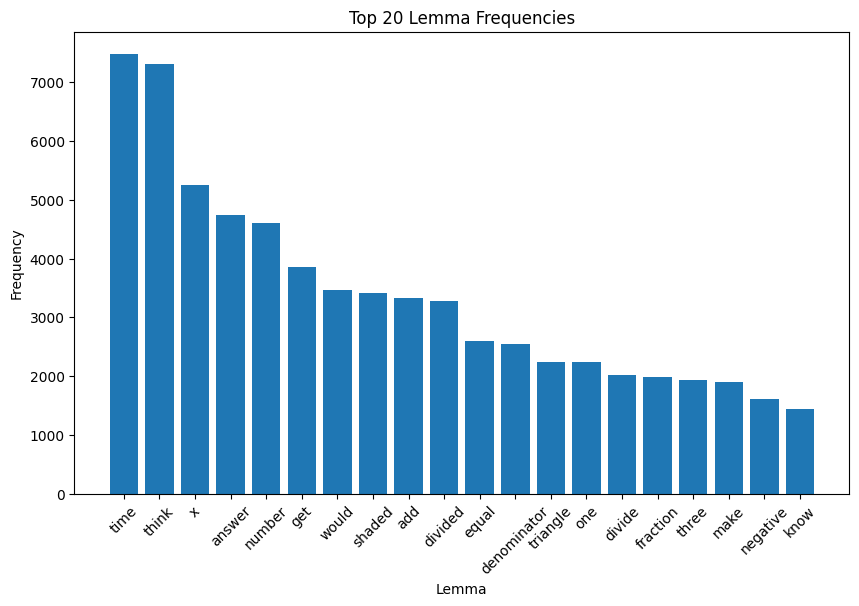

In [27]:
# Flatten all lemmas into one list
all_lemmas = [lemma for lemmas in train['lemmas'] for lemma in lemmas]

# Count lemma frequencies
lemma_counts = Counter(all_lemmas)
lemma_df = (
    pd.DataFrame(lemma_counts.items(), columns=['lemma', 'count'])
    .sort_values(by='count', ascending=False)
)

# Plot top N lemmas
top_n = 20
plt.figure(figsize=(10,6))
plt.bar(lemma_df['lemma'][:top_n], lemma_df['count'][:top_n])
plt.xticks(rotation=45)
plt.title(f"Top {top_n} Lemma Frequencies")
plt.xlabel("Lemma")
plt.ylabel("Frequency")
plt.show()

The top 20 lemmas are largely composed of math terms ('divided', 'X' for multiplication,'time' probably also for 'times' in multiplication, 'fraction')

Interestingly, we see 'think' a lot more than 'know'